In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, concatenate

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1, 7"

### Dataset

In [4]:
dataset = pd.read_csv('../../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [5]:
# # Plot Pearson correlation matrix
# import seaborn as sns

# correlations = data.corr(method='pearson')
# fig = plt.figure(figsize=(24, 24))
# sns.heatmap(correlations, annot=True, fmt='.2f')
# plt.title('Pearson Correlation Matrix')
# plt.show()

In [6]:
# data.tail(10)

### Dataset Information

In [7]:
print(list(data.columns))

['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual', 'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona', 'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia', 'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville', 'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river', 'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia', 'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']


### Pre-processing

In [8]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### Stage

In [9]:
# Pre-processing
# Stage --> 8 stages
pms = dataset[['price']]
print("pms.shape:", pms.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
pms_supervised = series_to_supervised(pms, n_hours, K)
pms_supervised.reset_index(drop=True, inplace=True)
print("pms_supervised.shape:", pms_supervised.shape)

pms.shape: (35063, 1)
pms_supervised.shape: (34968, 96)


In [10]:
# pms_supervised

#### Prior known covariates (9)

In [11]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
prior_known_cov = data[['price_dayahead','gen_coal', 'gen_gas', 'load_actual', 'gen_lig', 'gen_oil', \
                        'gen_oth_renew', 'pressure_Barcelona', 'pressure_Bilbao', \
                        'gen_waste', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (35063, 13)
prior_known_cov_supervised.shape: (34968, 1248)


In [12]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [13]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23),past_known_cov_var11(t+23),past_known_cov_var12(t+23),past_known_cov_var13(t+23)
0,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,195.0,...,25069.0,326.0,352.0,72.0,1030.0,1033.0,158.0,7351.0,1.0,650.0
1,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,196.0,...,23390.0,104.0,310.0,74.0,1027.0,1032.0,153.0,7403.0,1.0,938.0
2,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,191.0,...,21988.0,0.0,311.0,75.0,1027.0,1032.0,156.0,7887.0,1.0,1021.0
3,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,189.0,...,21182.0,0.0,308.0,71.0,1027.0,1031.0,155.0,8348.0,1.0,2067.0
4,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,188.0,...,20778.0,0.0,308.0,71.0,1026.0,1031.0,155.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,70.00,2923.0,13280.0,33142.0,721.0,308.0,95.0,1027.0,1028.0,307.0,...,30653.0,0.0,178.0,95.0,1027.0,1033.0,277.0,3113.0,1.0,1.0
34964,70.01,2932.0,13091.0,32669.0,721.0,308.0,98.0,1027.0,1028.0,306.0,...,29735.0,0.0,174.0,95.0,1027.0,1034.0,280.0,3288.0,1.0,1.0
34965,68.71,2941.0,11128.0,30753.0,721.0,307.0,95.0,1027.0,1029.0,304.0,...,28071.0,0.0,168.0,94.0,1028.0,1034.0,286.0,3503.0,1.0,50.0
34966,68.40,2921.0,9240.0,27882.0,705.0,306.0,96.0,1027.0,1029.0,308.0,...,25801.0,0.0,163.0,93.0,1028.0,1034.0,287.0,3586.0,2.0,108.0


In [14]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var10(t),...,past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23),past_known_cov_var11(t+23),past_known_cov_var12(t+23),past_known_cov_var13(t+23)
0,20.20,2755.0,3997.0,23620.0,0.0,310.0,58.0,1027.0,1037.0,160.0,...,25069.0,326.0,352.0,72.0,1030.0,1033.0,158.0,7351.0,1.0,650.0
1,19.16,2678.0,3787.0,22606.0,0.0,306.0,57.0,1027.0,1037.0,161.0,...,23390.0,104.0,310.0,74.0,1027.0,1032.0,153.0,7403.0,1.0,938.0
2,21.90,2426.0,3724.0,22191.0,0.0,311.0,56.0,1028.0,1036.0,162.0,...,21988.0,0.0,311.0,75.0,1027.0,1032.0,156.0,7887.0,1.0,1021.0
3,14.90,2046.0,3578.0,21929.0,0.0,310.0,56.0,1027.0,1036.0,161.0,...,21182.0,0.0,308.0,71.0,1027.0,1031.0,155.0,8348.0,1.0,2067.0
4,24.65,2248.0,3676.0,22195.0,0.0,310.0,58.0,1027.0,1036.0,157.0,...,20778.0,0.0,308.0,71.0,1026.0,1031.0,155.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,67.83,1556.0,5683.0,30042.0,0.0,221.0,97.0,1027.0,1034.0,311.0,...,30653.0,0.0,178.0,95.0,1027.0,1033.0,277.0,3113.0,1.0,1.0
34964,68.40,1616.0,5859.0,30229.0,0.0,216.0,96.0,1027.0,1035.0,314.0,...,29735.0,0.0,174.0,95.0,1027.0,1034.0,280.0,3288.0,1.0,1.0
34965,67.64,1610.0,5660.0,29145.0,0.0,215.0,98.0,1028.0,1035.0,316.0,...,28071.0,0.0,168.0,94.0,1028.0,1034.0,286.0,3503.0,1.0,50.0
34966,65.27,1622.0,5603.0,26934.0,0.0,225.0,98.0,1028.0,1035.0,309.0,...,25801.0,0.0,163.0,93.0,1028.0,1034.0,287.0,3586.0,2.0,108.0


In [15]:
prior_known_future_cov.shape

(34968, 312)

### N_out, N_in, K

In [16]:
# specify the number of lag hours
n_features = pms.shape[1] + prior_known_cov.shape[1]
n_features

14

### Concatenation

In [17]:
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [18]:
columns = []
for i in range(n_hours):
    #columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [19]:
past_unknown_known_cov = concat([
                                #past_prior_unknown_cov_supervised, 
                                past_prior_known_cov_supervised],
                                axis=1)

In [20]:
past_unknown_known_cov

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1),past_known_cov_var10(t-1),past_known_cov_var11(t-1),past_known_cov_var12(t-1),past_known_cov_var13(t-1)
0,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,195.0,...,25254.0,0.0,323.0,58.0,1028.0,1037.0,162.0,8540.0,0.0,1045.0
1,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,196.0,...,23620.0,0.0,310.0,58.0,1027.0,1037.0,160.0,8080.0,0.0,1257.0
2,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,191.0,...,22606.0,0.0,306.0,57.0,1027.0,1037.0,161.0,7773.0,1.0,1629.0
3,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,189.0,...,22191.0,0.0,311.0,56.0,1028.0,1036.0,162.0,7601.0,1.0,1962.0
4,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,188.0,...,21929.0,0.0,310.0,56.0,1027.0,1036.0,161.0,7584.0,1.0,2185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,70.00,2923.0,13280.0,33142.0,721.0,308.0,95.0,1027.0,1028.0,307.0,...,29221.0,0.0,228.0,96.0,1027.0,1034.0,311.0,5129.0,1.0,1.0
34964,70.01,2932.0,13091.0,32669.0,721.0,308.0,98.0,1027.0,1028.0,306.0,...,30042.0,0.0,221.0,97.0,1027.0,1034.0,311.0,5406.0,1.0,1.0
34965,68.71,2941.0,11128.0,30753.0,721.0,307.0,95.0,1027.0,1029.0,304.0,...,30229.0,0.0,216.0,96.0,1027.0,1035.0,314.0,5193.0,0.0,1.0
34966,68.40,2921.0,9240.0,27882.0,705.0,306.0,96.0,1027.0,1029.0,308.0,...,29145.0,0.0,215.0,98.0,1028.0,1035.0,316.0,4912.0,1.0,1.0


In [21]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, pms_supervised.iloc[:, :]], axis=1)

In [22]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 1032)


In [23]:
# all_data

### Train & Test set

In [24]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [25]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 28050


In [26]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [27]:
test_future_cov.shape

(6918, 312)

### Normalization

In [28]:
n_hours

72

In [29]:
n_features

14

In [30]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (28050, 1008) (28050, 24) (6918, 1008) (6918, 24)


In [31]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (28050, 312) (6918, 312)


In [32]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (28050, 72, 14) (28050, 24) (6918, 72, 14) (6918, 24)


In [33]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (28050, 24, 13) (6918, 24, 13)


In [34]:
# train_y = train_y.reshape((train_y.shape[0], K, -1))
# test_y = test_y.reshape((test_y.shape[0], K, -1))
# print(train_y.shape, test_y.shape)

In [35]:
# past_inputs

### Model

In [39]:
# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='past_inputs')
encoder = tf.keras.layers.SimpleRNN(128, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_inputs)
encoder = tf.keras.layers.SimpleRNN(64, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.SimpleRNN(32, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.SimpleRNN(13, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)


# Combine past + future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='future_inputs')

past_future_input = concatenate([encoder, future_inputs], axis=1)


# decoder
decoder = tf.keras.layers.SimpleRNN(128, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_future_input)
decoder = tf.keras.layers.SimpleRNN(64, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.SimpleRNN(32, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.SimpleRNN(16, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)

fc = layers.Flatten()(decoder)

# final output
fc = tf.keras.layers.Dense(256, activation='relu')(fc)
fc = tf.keras.layers.Dense(128, activation='relu')(fc)
fc = tf.keras.layers.Dense(64, activation='relu')(fc)
output = tf.keras.layers.Dense(train_y.shape[1])(fc)

model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 72, 14)]     0                                            
__________________________________________________________________________________________________
simple_rnn_16 (SimpleRNN)       (None, 72, 128)      18304       past_inputs[0][0]                
__________________________________________________________________________________________________
simple_rnn_17 (SimpleRNN)       (None, 72, 64)       12352       simple_rnn_16[0][0]              
__________________________________________________________________________________________________
simple_rnn_18 (SimpleRNN)       (None, 72, 32)       3104        simple_rnn_17[0][0]              
____________________________________________________________________________________________

Epoch 1/6000

Epoch 00001: val_mae improved from inf to 0.14609, saving model to saved_model/rnn_encoder_decoder_24h_energy_cp1.h5
55/55 - 30s - loss: 0.0954 - mae: 0.1251 - val_loss: 0.0902 - val_mae: 0.1461
Epoch 2/6000

Epoch 00002: val_mae improved from 0.14609 to 0.10559, saving model to saved_model/rnn_encoder_decoder_24h_energy_cp1.h5
55/55 - 28s - loss: 0.0663 - mae: 0.0672 - val_loss: 0.0718 - val_mae: 0.1056
Epoch 3/6000

Epoch 00003: val_mae improved from 0.10559 to 0.08846, saving model to saved_model/rnn_encoder_decoder_24h_energy_cp1.h5
55/55 - 28s - loss: 0.0588 - mae: 0.0582 - val_loss: 0.0623 - val_mae: 0.0885
Epoch 4/6000

Epoch 00004: val_mae improved from 0.08846 to 0.07461, saving model to saved_model/rnn_encoder_decoder_24h_energy_cp1.h5
55/55 - 29s - loss: 0.0533 - mae: 0.0531 - val_loss: 0.0552 - val_mae: 0.0746
Epoch 5/6000

Epoch 00005: val_mae did not improve from 0.07461
55/55 - 28s - loss: 0.0490 - mae: 0.0501 - val_loss: 0.0529 - val_mae: 0.0806
Epoch 6/60

Epoch 52/6000

Epoch 00052: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0162 - mae: 0.0305 - val_loss: 0.0206 - val_mae: 0.0580
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0160 - mae: 0.0307 - val_loss: 0.0200 - val_mae: 0.0555
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0158 - mae: 0.0309 - val_loss: 0.0206 - val_mae: 0.0608
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0156 - mae: 0.0312 - val_loss: 0.0205 - val_mae: 0.0611
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0153 - mae: 0.0302 - val_loss: 0.0193 - val_mae: 0.0557
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0152 - mae: 0.0315 - val_loss: 0.0195 - val_mae: 0.0571
Epoch 58/6000

Epoch 00058: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0149 - mae: 0.0304 - val_loss: 0.0189 - val_mae: 0.0554

Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0077 - mae: 0.0267 - val_loss: 0.0137 - val_mae: 0.0639
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0078 - mae: 0.0276 - val_loss: 0.0139 - val_mae: 0.0650
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0075 - mae: 0.0259 - val_loss: 0.0139 - val_mae: 0.0656
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0075 - mae: 0.0266 - val_loss: 0.0132 - val_mae: 0.0618
Epoch 114/6000

Epoch 00114: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0074 - mae: 0.0262 - val_loss: 0.0120 - val_mae: 0.0562
Epoch 115/6000

Epoch 00115: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0073 - mae: 0.0258 - val_loss: 0.0127 - val_mae: 0.0600
Epoch 116/6000

Epoch 00116: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0072 - mae: 0.0257 - val_loss: 0.0123 - val_mae:

Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0047 - mae: 0.0238 - val_loss: 0.0101 - val_mae: 0.0580
Epoch 168/6000

Epoch 00168: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0046 - mae: 0.0236 - val_loss: 0.0099 - val_mae: 0.0572
Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0046 - mae: 0.0236 - val_loss: 0.0112 - val_mae: 0.0646
Epoch 170/6000

Epoch 00170: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0046 - mae: 0.0235 - val_loss: 0.0104 - val_mae: 0.0605
Epoch 171/6000

Epoch 00171: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0045 - mae: 0.0236 - val_loss: 0.0104 - val_mae: 0.0612
Epoch 172/6000

Epoch 00172: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0045 - mae: 0.0238 - val_loss: 0.0106 - val_mae: 0.0620
Epoch 173/6000

Epoch 00173: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0045 - mae: 0.0240 - val_loss: 0.0112 - val_mae:

Epoch 224/6000

Epoch 00224: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0032 - mae: 0.0216 - val_loss: 0.0122 - val_mae: 0.0770
Epoch 225/6000

Epoch 00225: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0033 - mae: 0.0221 - val_loss: 0.0090 - val_mae: 0.0593
Epoch 226/6000

Epoch 00226: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0032 - mae: 0.0221 - val_loss: 0.0087 - val_mae: 0.0575
Epoch 227/6000

Epoch 00227: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0032 - mae: 0.0221 - val_loss: 0.0096 - val_mae: 0.0627
Epoch 228/6000

Epoch 00228: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0032 - mae: 0.0218 - val_loss: 0.0090 - val_mae: 0.0589
Epoch 229/6000

Epoch 00229: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0032 - mae: 0.0225 - val_loss: 0.0095 - val_mae: 0.0624
Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0032 - mae: 0.0215 - val_loss: 0.0090 - val_mae:

Epoch 281/6000

Epoch 00281: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0204 - val_loss: 0.0087 - val_mae: 0.0614
Epoch 282/6000

Epoch 00282: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0206 - val_loss: 0.0093 - val_mae: 0.0646
Epoch 283/6000

Epoch 00283: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0205 - val_loss: 0.0081 - val_mae: 0.0577
Epoch 284/6000

Epoch 00284: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0210 - val_loss: 0.0087 - val_mae: 0.0617
Epoch 285/6000

Epoch 00285: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0204 - val_loss: 0.0092 - val_mae: 0.0638
Epoch 286/6000

Epoch 00286: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0207 - val_loss: 0.0092 - val_mae: 0.0637
Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0025 - mae: 0.0207 - val_loss: 0.0080 - val_mae:

Epoch 338/6000

Epoch 00338: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0021 - mae: 0.0198 - val_loss: 0.0083 - val_mae: 0.0614
Epoch 339/6000

Epoch 00339: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0020 - mae: 0.0193 - val_loss: 0.0073 - val_mae: 0.0552
Epoch 340/6000

Epoch 00340: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0021 - mae: 0.0198 - val_loss: 0.0083 - val_mae: 0.0611
Epoch 341/6000

Epoch 00341: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0020 - mae: 0.0194 - val_loss: 0.0079 - val_mae: 0.0593
Epoch 342/6000

Epoch 00342: val_mae did not improve from 0.05258
55/55 - 33s - loss: 0.0020 - mae: 0.0195 - val_loss: 0.0083 - val_mae: 0.0609
Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.05258
55/55 - 33s - loss: 0.0020 - mae: 0.0194 - val_loss: 0.0090 - val_mae: 0.0658
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.05258
55/55 - 33s - loss: 0.0020 - mae: 0.0193 - val_loss: 0.0079 - val_mae:

Epoch 395/6000

Epoch 00395: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0018 - mae: 0.0189 - val_loss: 0.0077 - val_mae: 0.0591
Epoch 396/6000

Epoch 00396: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0018 - mae: 0.0186 - val_loss: 0.0077 - val_mae: 0.0598
Epoch 397/6000

Epoch 00397: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0018 - mae: 0.0189 - val_loss: 0.0079 - val_mae: 0.0598
Epoch 398/6000

Epoch 00398: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0018 - mae: 0.0187 - val_loss: 0.0080 - val_mae: 0.0606
Epoch 399/6000

Epoch 00399: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0018 - mae: 0.0185 - val_loss: 0.0075 - val_mae: 0.0580
Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0018 - mae: 0.0190 - val_loss: 0.0080 - val_mae: 0.0607
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0018 - mae: 0.0191 - val_loss: 0.0081 - val_mae:

Epoch 452/6000

Epoch 00452: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0016 - mae: 0.0182 - val_loss: 0.0080 - val_mae: 0.0614
Epoch 453/6000

Epoch 00453: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0016 - mae: 0.0182 - val_loss: 0.0080 - val_mae: 0.0616
Epoch 454/6000

Epoch 00454: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0016 - mae: 0.0184 - val_loss: 0.0083 - val_mae: 0.0634
Epoch 455/6000

Epoch 00455: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0016 - mae: 0.0181 - val_loss: 0.0080 - val_mae: 0.0619
Epoch 456/6000

Epoch 00456: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0016 - mae: 0.0181 - val_loss: 0.0079 - val_mae: 0.0606
Epoch 457/6000

Epoch 00457: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0016 - mae: 0.0178 - val_loss: 0.0084 - val_mae: 0.0637
Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0016 - mae: 0.0186 - val_loss: 0.0087 - val_mae:

Epoch 509/6000

Epoch 00509: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0173 - val_loss: 0.0085 - val_mae: 0.0644
Epoch 510/6000

Epoch 00510: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0175 - val_loss: 0.0081 - val_mae: 0.0617
Epoch 511/6000

Epoch 00511: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0174 - val_loss: 0.0088 - val_mae: 0.0668
Epoch 512/6000

Epoch 00512: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0174 - val_loss: 0.0089 - val_mae: 0.0666
Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0177 - val_loss: 0.0108 - val_mae: 0.0767
Epoch 514/6000

Epoch 00514: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0015 - mae: 0.0179 - val_loss: 0.0084 - val_mae: 0.0642
Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0173 - val_loss: 0.0086 - val_mae:

Epoch 566/6000

Epoch 00566: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0013 - mae: 0.0171 - val_loss: 0.0088 - val_mae: 0.0662
Epoch 567/6000

Epoch 00567: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0013 - mae: 0.0169 - val_loss: 0.0087 - val_mae: 0.0653
Epoch 568/6000

Epoch 00568: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0013 - mae: 0.0168 - val_loss: 0.0090 - val_mae: 0.0681
Epoch 569/6000

Epoch 00569: val_mae did not improve from 0.05258
55/55 - 28s - loss: 0.0013 - mae: 0.0169 - val_loss: 0.0095 - val_mae: 0.0707
Epoch 570/6000

Epoch 00570: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0014 - mae: 0.0176 - val_loss: 0.0081 - val_mae: 0.0617
Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0013 - mae: 0.0172 - val_loss: 0.0091 - val_mae: 0.0673
Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0013 - mae: 0.0169 - val_loss: 0.0090 - val_mae:

Epoch 623/6000

Epoch 00623: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0088 - val_mae: 0.0661
Epoch 624/6000

Epoch 00624: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0080 - val_mae: 0.0618
Epoch 625/6000

Epoch 00625: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0013 - mae: 0.0171 - val_loss: 0.0091 - val_mae: 0.0677
Epoch 626/6000

Epoch 00626: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0094 - val_mae: 0.0694
Epoch 627/6000

Epoch 00627: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0012 - mae: 0.0165 - val_loss: 0.0093 - val_mae: 0.0689
Epoch 628/6000

Epoch 00628: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0093 - val_mae: 0.0685
Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0013 - mae: 0.0171 - val_loss: 0.0092 - val_mae:

Epoch 680/6000

Epoch 00680: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0012 - mae: 0.0163 - val_loss: 0.0093 - val_mae: 0.0688
Epoch 681/6000

Epoch 00681: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0012 - mae: 0.0164 - val_loss: 0.0084 - val_mae: 0.0646
Epoch 682/6000

Epoch 00682: val_mae did not improve from 0.05258
55/55 - 32s - loss: 0.0012 - mae: 0.0165 - val_loss: 0.0087 - val_mae: 0.0657
Epoch 683/6000

Epoch 00683: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0012 - mae: 0.0163 - val_loss: 0.0077 - val_mae: 0.0604
Epoch 684/6000

Epoch 00684: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0012 - mae: 0.0169 - val_loss: 0.0085 - val_mae: 0.0645
Epoch 685/6000

Epoch 00685: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0012 - mae: 0.0162 - val_loss: 0.0085 - val_mae: 0.0644
Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0012 - mae: 0.0163 - val_loss: 0.0086 - val_mae:

Epoch 737/6000

Epoch 00737: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0160 - val_loss: 0.0092 - val_mae: 0.0687
Epoch 738/6000

Epoch 00738: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0084 - val_mae: 0.0642
Epoch 739/6000

Epoch 00739: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0076 - val_mae: 0.0595
Epoch 740/6000

Epoch 00740: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0162 - val_loss: 0.0096 - val_mae: 0.0709
Epoch 741/6000

Epoch 00741: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0160 - val_loss: 0.0087 - val_mae: 0.0651
Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0160 - val_loss: 0.0090 - val_mae: 0.0671
Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0157 - val_loss: 0.0082 - val_mae:

Epoch 794/6000

Epoch 00794: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0011 - mae: 0.0158 - val_loss: 0.0090 - val_mae: 0.0681
Epoch 795/6000

Epoch 00795: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0011 - mae: 0.0162 - val_loss: 0.0087 - val_mae: 0.0655
Epoch 796/6000

Epoch 00796: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0160 - val_loss: 0.0086 - val_mae: 0.0660
Epoch 797/6000

Epoch 00797: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0011 - mae: 0.0156 - val_loss: 0.0092 - val_mae: 0.0686
Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0011 - mae: 0.0155 - val_loss: 0.0087 - val_mae: 0.0661
Epoch 799/6000

Epoch 00799: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0155 - val_loss: 0.0089 - val_mae: 0.0666
Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.05258
55/55 - 31s - loss: 0.0011 - mae: 0.0156 - val_loss: 0.0081 - val_mae:

Epoch 851/6000

Epoch 00851: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0010 - mae: 0.0155 - val_loss: 0.0092 - val_mae: 0.0688
Epoch 852/6000

Epoch 00852: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0010 - mae: 0.0154 - val_loss: 0.0088 - val_mae: 0.0663
Epoch 853/6000

Epoch 00853: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0010 - mae: 0.0158 - val_loss: 0.0089 - val_mae: 0.0671
Epoch 854/6000

Epoch 00854: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0010 - mae: 0.0157 - val_loss: 0.0095 - val_mae: 0.0708
Epoch 855/6000

Epoch 00855: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0010 - mae: 0.0156 - val_loss: 0.0095 - val_mae: 0.0704
Epoch 856/6000

Epoch 00856: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0010 - mae: 0.0154 - val_loss: 0.0090 - val_mae: 0.0676
Epoch 857/6000

Epoch 00857: val_mae did not improve from 0.05258
55/55 - 29s - loss: 0.0010 - mae: 0.0158 - val_loss: 0.0090 - val_mae:

Epoch 908/6000

Epoch 00908: val_mae did not improve from 0.05258
55/55 - 30s - loss: 9.9225e-04 - mae: 0.0153 - val_loss: 0.0092 - val_mae: 0.0688
Epoch 909/6000

Epoch 00909: val_mae did not improve from 0.05258
55/55 - 30s - loss: 9.9703e-04 - mae: 0.0154 - val_loss: 0.0084 - val_mae: 0.0643
Epoch 910/6000

Epoch 00910: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0010 - mae: 0.0157 - val_loss: 0.0089 - val_mae: 0.0672
Epoch 911/6000

Epoch 00911: val_mae did not improve from 0.05258
55/55 - 31s - loss: 9.9445e-04 - mae: 0.0153 - val_loss: 0.0087 - val_mae: 0.0658
Epoch 912/6000

Epoch 00912: val_mae did not improve from 0.05258
55/55 - 31s - loss: 9.9453e-04 - mae: 0.0153 - val_loss: 0.0090 - val_mae: 0.0672
Epoch 913/6000

Epoch 00913: val_mae did not improve from 0.05258
55/55 - 30s - loss: 0.0010 - mae: 0.0157 - val_loss: 0.0095 - val_mae: 0.0705
Epoch 914/6000

Epoch 00914: val_mae did not improve from 0.05258
55/55 - 31s - loss: 9.8121e-04 - mae: 0.0151 - val_los

Epoch 964/6000

Epoch 00964: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.5561e-04 - mae: 0.0149 - val_loss: 0.0087 - val_mae: 0.0664
Epoch 965/6000

Epoch 00965: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.7856e-04 - mae: 0.0154 - val_loss: 0.0090 - val_mae: 0.0677
Epoch 966/6000

Epoch 00966: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.7120e-04 - mae: 0.0152 - val_loss: 0.0091 - val_mae: 0.0677
Epoch 967/6000

Epoch 00967: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.7526e-04 - mae: 0.0153 - val_loss: 0.0099 - val_mae: 0.0730
Epoch 968/6000

Epoch 00968: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.9534e-04 - mae: 0.0157 - val_loss: 0.0094 - val_mae: 0.0699
Epoch 969/6000

Epoch 00969: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.6116e-04 - mae: 0.0150 - val_loss: 0.0086 - val_mae: 0.0656
Epoch 970/6000

Epoch 00970: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.5878e-04 - mae: 0.0150 -

Epoch 1020/6000

Epoch 01020: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.4392e-04 - mae: 0.0150 - val_loss: 0.0096 - val_mae: 0.0710
Epoch 1021/6000

Epoch 01021: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.3490e-04 - mae: 0.0148 - val_loss: 0.0088 - val_mae: 0.0665
Epoch 1022/6000

Epoch 01022: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.5608e-04 - mae: 0.0152 - val_loss: 0.0096 - val_mae: 0.0709
Epoch 1023/6000

Epoch 01023: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.5263e-04 - mae: 0.0151 - val_loss: 0.0093 - val_mae: 0.0695
Epoch 1024/6000

Epoch 01024: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.3268e-04 - mae: 0.0147 - val_loss: 0.0091 - val_mae: 0.0683
Epoch 1025/6000

Epoch 01025: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.3855e-04 - mae: 0.0149 - val_loss: 0.0087 - val_mae: 0.0659
Epoch 1026/6000

Epoch 01026: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.2825e-04 - mae: 0

Epoch 1075/6000

Epoch 01075: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.2323e-04 - mae: 0.0148 - val_loss: 0.0094 - val_mae: 0.0696
Epoch 1076/6000

Epoch 01076: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.2412e-04 - mae: 0.0148 - val_loss: 0.0096 - val_mae: 0.0711
Epoch 1077/6000

Epoch 01077: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.1730e-04 - mae: 0.0147 - val_loss: 0.0097 - val_mae: 0.0717
Epoch 1078/6000

Epoch 01078: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.2146e-04 - mae: 0.0147 - val_loss: 0.0089 - val_mae: 0.0670
Epoch 1079/6000

Epoch 01079: val_mae did not improve from 0.05258
55/55 - 28s - loss: 9.4880e-04 - mae: 0.0153 - val_loss: 0.0092 - val_mae: 0.0683
Epoch 1080/6000

Epoch 01080: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.2349e-04 - mae: 0.0148 - val_loss: 0.0097 - val_mae: 0.0717
Epoch 1081/6000

Epoch 01081: val_mae did not improve from 0.05258
55/55 - 29s - loss: 9.2247e-04 - mae: 0

Epoch 1130/6000

Epoch 01130: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.9580e-04 - mae: 0.0144 - val_loss: 0.0093 - val_mae: 0.0695
Epoch 1131/6000

Epoch 01131: val_mae did not improve from 0.05258
55/55 - 19s - loss: 9.0774e-04 - mae: 0.0147 - val_loss: 0.0091 - val_mae: 0.0681
Epoch 1132/6000

Epoch 01132: val_mae did not improve from 0.05258
55/55 - 19s - loss: 9.1228e-04 - mae: 0.0148 - val_loss: 0.0099 - val_mae: 0.0726
Epoch 1133/6000

Epoch 01133: val_mae did not improve from 0.05258
55/55 - 19s - loss: 9.0489e-04 - mae: 0.0146 - val_loss: 0.0094 - val_mae: 0.0693
Epoch 1134/6000

Epoch 01134: val_mae did not improve from 0.05258
55/55 - 18s - loss: 8.9945e-04 - mae: 0.0145 - val_loss: 0.0095 - val_mae: 0.0710
Epoch 1135/6000

Epoch 01135: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.9596e-04 - mae: 0.0144 - val_loss: 0.0096 - val_mae: 0.0709
Epoch 1136/6000

Epoch 01136: val_mae did not improve from 0.05258
55/55 - 18s - loss: 9.1257e-04 - mae: 0

Epoch 1185/6000

Epoch 01185: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.9359e-04 - mae: 0.0146 - val_loss: 0.0094 - val_mae: 0.0699
Epoch 1186/6000

Epoch 01186: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.9359e-04 - mae: 0.0146 - val_loss: 0.0094 - val_mae: 0.0699
Epoch 1187/6000

Epoch 01187: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.8986e-04 - mae: 0.0145 - val_loss: 0.0090 - val_mae: 0.0677
Epoch 1188/6000

Epoch 01188: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.9748e-04 - mae: 0.0147 - val_loss: 0.0092 - val_mae: 0.0686
Epoch 1189/6000

Epoch 01189: val_mae did not improve from 0.05258
55/55 - 19s - loss: 9.0462e-04 - mae: 0.0148 - val_loss: 0.0087 - val_mae: 0.0659
Epoch 1190/6000

Epoch 01190: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.8398e-04 - mae: 0.0144 - val_loss: 0.0091 - val_mae: 0.0678
Epoch 1191/6000

Epoch 01191: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.8055e-04 - mae: 0

Epoch 1240/6000

Epoch 01240: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.6400e-04 - mae: 0.0142 - val_loss: 0.0094 - val_mae: 0.0697
Epoch 1241/6000

Epoch 01241: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.6366e-04 - mae: 0.0142 - val_loss: 0.0087 - val_mae: 0.0654
Epoch 1242/6000

Epoch 01242: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.6903e-04 - mae: 0.0143 - val_loss: 0.0096 - val_mae: 0.0710
Epoch 1243/6000

Epoch 01243: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.6261e-04 - mae: 0.0142 - val_loss: 0.0094 - val_mae: 0.0703
Epoch 1244/6000

Epoch 01244: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.9227e-04 - mae: 0.0148 - val_loss: 0.0089 - val_mae: 0.0673
Epoch 1245/6000

Epoch 01245: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.7352e-04 - mae: 0.0144 - val_loss: 0.0092 - val_mae: 0.0695
Epoch 1246/6000

Epoch 01246: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.8936e-04 - mae: 0

Epoch 1295/6000

Epoch 01295: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.7748e-04 - mae: 0.0146 - val_loss: 0.0093 - val_mae: 0.0689
Epoch 1296/6000

Epoch 01296: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.5143e-04 - mae: 0.0141 - val_loss: 0.0097 - val_mae: 0.0713
Epoch 1297/6000

Epoch 01297: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.4713e-04 - mae: 0.0140 - val_loss: 0.0103 - val_mae: 0.0746
Epoch 1298/6000

Epoch 01298: val_mae did not improve from 0.05258
55/55 - 18s - loss: 8.6825e-04 - mae: 0.0145 - val_loss: 0.0090 - val_mae: 0.0681
Epoch 1299/6000

Epoch 01299: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.5533e-04 - mae: 0.0142 - val_loss: 0.0089 - val_mae: 0.0667
Epoch 1300/6000

Epoch 01300: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.5169e-04 - mae: 0.0141 - val_loss: 0.0090 - val_mae: 0.0680
Epoch 1301/6000

Epoch 01301: val_mae did not improve from 0.05258
55/55 - 18s - loss: 8.4807e-04 - mae: 0

Epoch 1350/6000

Epoch 01350: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.3616e-04 - mae: 0.0140 - val_loss: 0.0090 - val_mae: 0.0678
Epoch 1351/6000

Epoch 01351: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.3281e-04 - mae: 0.0139 - val_loss: 0.0089 - val_mae: 0.0670
Epoch 1352/6000

Epoch 01352: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.4721e-04 - mae: 0.0142 - val_loss: 0.0091 - val_mae: 0.0682
Epoch 1353/6000

Epoch 01353: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.3465e-04 - mae: 0.0140 - val_loss: 0.0092 - val_mae: 0.0689
Epoch 1354/6000

Epoch 01354: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.4305e-04 - mae: 0.0141 - val_loss: 0.0085 - val_mae: 0.0644
Epoch 1355/6000

Epoch 01355: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.7080e-04 - mae: 0.0147 - val_loss: 0.0092 - val_mae: 0.0682
Epoch 1356/6000

Epoch 01356: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.5476e-04 - mae: 0

Epoch 1405/6000

Epoch 01405: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.3466e-04 - mae: 0.0142 - val_loss: 0.0095 - val_mae: 0.0708
Epoch 1406/6000

Epoch 01406: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.2175e-04 - mae: 0.0139 - val_loss: 0.0086 - val_mae: 0.0650
Epoch 1407/6000

Epoch 01407: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.2439e-04 - mae: 0.0140 - val_loss: 0.0090 - val_mae: 0.0671
Epoch 1408/6000

Epoch 01408: val_mae did not improve from 0.05258
55/55 - 18s - loss: 8.3093e-04 - mae: 0.0141 - val_loss: 0.0089 - val_mae: 0.0667
Epoch 1409/6000

Epoch 01409: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.2793e-04 - mae: 0.0140 - val_loss: 0.0091 - val_mae: 0.0683
Epoch 1410/6000

Epoch 01410: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.1783e-04 - mae: 0.0138 - val_loss: 0.0094 - val_mae: 0.0693
Epoch 1411/6000

Epoch 01411: val_mae did not improve from 0.05258
55/55 - 19s - loss: 8.5152e-04 - mae: 0

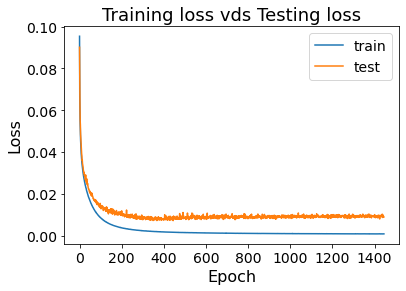

In [40]:
lr = 0.00001
EPOCHS = 6000


lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
                optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_encoder_decoder_24h_energy_cp1.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [41]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/rnn_encoder_decoder_24h_energy_cp1.h5')

In [42]:
y_hat = model.predict([test_X, test_future_cov])

In [43]:
print(y_hat.shape)
print(test_y.shape)

(6918, 24)
(6918, 24)


In [44]:
# print(y_hat.shape)
# y_hat = y_hat.reshape((-1, y_hat.shape[1]*y_hat.shape[2]))
# print(y_hat.shape)

In [45]:
# print(test_y.shape)
# test_y = test_y.reshape((-1, test_y.shape[1]*test_y.shape[2]))
# # print(test_y.shape)

In [46]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (6918, 24) (6918, 24)


### Performance

In [47]:
# K=24h
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 4.273
RMSE = 5.742
